# Notebook to analyse data

### **Imports**

In [1]:
import diplib as dip
import numpy as np
import matplotlib.pyplot as plt
import sys

DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


##

In [2]:
def load_imgs(image, density):
    path = f'data/image{image}_100_{density}_10.ics'
    imgs = dip.ImageReadICS(path)
    
    return imgs

In [3]:
def create_gradient_array(rows, cols, start=1, end=0):
    x = np.linspace(start, end, cols)
    y = np.linspace(start, end, rows)
    xv, yv = np.meshgrid(x, y)

    gradient_array = (xv + yv) / 2.0

    return gradient_array

In [119]:
imgs = load_imgs(2,20)

max_frames = 100
frames = imgs.Sizes()[2]

measurements = []

_, rows, cols = np.asarray(imgs[:,:,0]).shape

for frame_num in range(frames):
    frame = np.asarray(imgs[:,:,frame_num])

    gradient_array = create_gradient_array(rows, cols, 40, 10)
    corrected_image = frame - gradient_array

    image_gauss = dip.Gauss(dip.Image(corrected_image), sigmas=[2])
    image_thres = dip.IsodataThreshold(image_gauss)
    image_label = dip.Label(image_thres)

    thres_hold_mask = dip.IsodataThreshold(frame)
    threshold_label = dip.Label(thres_hold_mask)
    measurement = dip.MeasurementTool.Measure(label=threshold_label, grey=frame, features=['Gravity'])

    measurements.append(measurement)

    if frame_num > 5000:
        break

In [120]:
coordinates = []
for idx, m in enumerate(measurements):
    for o in range(1,m.NumberOfObjects()):
        # print('\r' + f'Measurement: {idx} | Object: {o}', end='')
        coordinates.append(tuple(m['Gravity'][o][:2]))

coordinates = np.array(coordinates)
print('\nAmount of coordinates: {}'.format(len(coordinates)))


Amount of coordinates: 451477


In [121]:
rc = dip.Image(sizes=[640, 480], dt='SFLOAT')
rc.Fill(0)
for ii in coordinates:
    rc[round(ii[0]), round(ii[1])] = rc[round(ii[0]), round(ii[1])][0] + 1.0

In [123]:
dip.viewer.Show(rc)

### **Processing Steps**

#### **Functions**

In [123]:
def plot(
        image,
        image_array,
        gradient_array,
        corrected_image,
        image_mean_sub,
        image_gauss,
        image_thres,
        image_label,
        critical_points
):
        fig, ax = plt.subplots(4, 2, figsize=(9, 9), facecolor='black')
        c = (0,0)
        ax[c[0],c[1]].imshow(np.asarray(image), cmap='gray')
        ax[c[0],c[1]].set_title('Original Image', c='white')
        ax[c[0],c[1]].axis('off')

        c = (0,1)
        ax[c[0],c[1]].imshow(image_array, cmap='gray')
        ax[c[0],c[1]].set_title('Cropped Image', c='white')
        ax[c[0],c[1]].axis('off')

        c = (1,0)
        ax[c[0],c[1]].imshow(gradient_array, cmap='gray')
        ax[c[0],c[1]].set_title('Estimated Background', c='white')
        ax[c[0],c[1]].axis('off')

        c = (1,1)
        ax[c[0],c[1]].imshow(corrected_image, cmap='gray')
        ax[c[0],c[1]].set_title('Corrected Image', c='white')
        ax[c[0],c[1]].axis('off')

        c = (2,0)
        ax[c[0],c[1]].imshow(np.asarray(image_mean_sub), cmap='gray')
        ax[c[0],c[1]].set_title('Mean subtraction', c='white')
        ax[c[0],c[1]].axis('off')

        c = (2,1)
        ax[c[0],c[1]].imshow(np.asarray(image_gauss), cmap='gray')
        ax[c[0],c[1]].set_title('Gauss image', c='white')
        ax[c[0],c[1]].axis('off')

        c = (3,0)
        ax[c[0],c[1]].imshow(np.asarray(image_thres), cmap='gray')
        ax[c[0],c[1]].set_title('Theshold Image', c='white')
        ax[c[0],c[1]].axis('off')

        c = (3,1)
        ax[c[0],c[1]].imshow(np.asarray(image_label), cmap='gray')
        ax[c[0],c[1]].scatter(critical_points[:,0], critical_points[:,1], c='r', s=10, label='Found points')
        ax[c[0],c[1]].set_title('Label Image', c='white')
        ax[c[0],c[1]].axis('off')
        ax[c[0],c[1]].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

        plt.show()

def analyse_image(idx, crit_min_max, sigma): 
    image = load_imgs(2, 20)[:,:,idx].Squeeze()
    cropped_image = image[40:-50,100:]

    critical_size = crit_min_max # (min size, max size)

    image_array = np.asarray(cropped_image)

    rows = image_array.shape[0]
    cols = image_array.shape[1]

    gradient_array = create_gradient_array(rows, cols, 40, 10)
    corrected_image = (image_array - gradient_array).clip(min=0)

    image_mean_sub = (corrected_image - np.mean(corrected_image)).clip(min=0)

    image_gauss = dip.Gauss(dip.Image(image_mean_sub), sigmas=[sigma])
    image_thres = dip.IsodataThreshold(image_gauss)
    image_label = dip.Label(image_thres)

    measurement = dip.MeasurementTool.Measure(label=image_label, grey=cropped_image.Squeeze(), features=['Gravity', 'Size'])

    critical_points = np.array([measurement['Gravity'][i]
                                for i in range(1,measurement.NumberOfObjects())
                                if measurement['Size'][i][0] < critical_size[1] 
                                and measurement['Size'][i][0] > critical_size[0]])

    print(f'Critical size: {critical_size} | Amount of found points: {len(critical_points)}')
    plot(
        image,
        image_array,
        gradient_array,
        corrected_image,
        image_mean_sub,
        image_gauss,
        image_thres,
        image_label,
        critical_points
    )

#### **Analyse**

Critical size: (50, 1000) | Amount of found points: 14


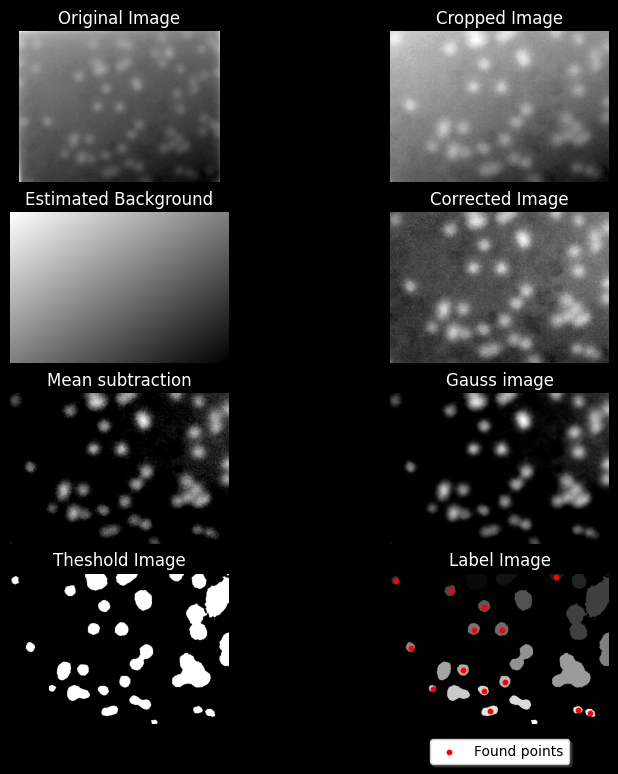

In [124]:
analyse_image(5, (50,1000), 2)